# Airborne MT forward modelling and inversion notebook V0.3

Note: this notebook can be modified to do qamt or controlled source. TODO

In [1]:
# import SimPEG.dask as simpeg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from SimPEG.electromagnetics import natural_source as ns
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver

from SimPEG.meta import MultiprocessingMetaSimulation

## Loading the simulation

Load the *.msh file and *.mod file which are UBC formatted. We can extract the active cells by searching for the value used to indicate air cells on line 10 of the following cell

A histogram of the model is generated to get an idea of how many units are present

(54504,) 54504 34840


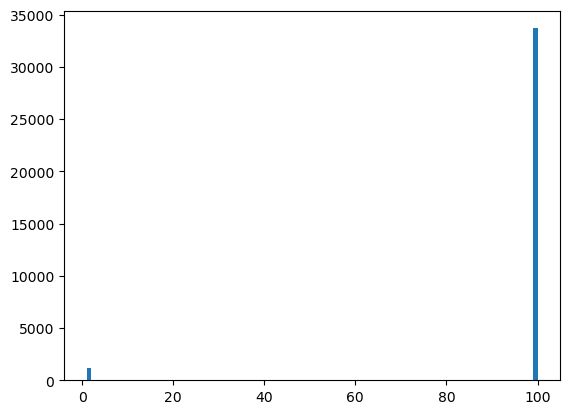

0.01 1.0


In [2]:
# let import the mesh in UBC format
mesh_file = r".\octree_mesh\octree_mesh.txt"
mesh = discretize.TreeMesh.read_UBC(mesh_file)

# load the conductivity model
conductivity_file = r".\octree_model\octree_model.con"
model = discretize.TreeMesh.read_model_UBC(mesh, conductivity_file)

# extract the acive files
active = model > 1e-8

# model[model == -1] = 50

print(model.shape, mesh.nC, active.sum())

plt.hist(1 / model[active], 100)
plt.show()

print(model[active].min(), model[active].max())


## Load the receiver stations array

Simply load in a CSV file with utm easting, northing and elevation.

receiver numbers: (169, 3)


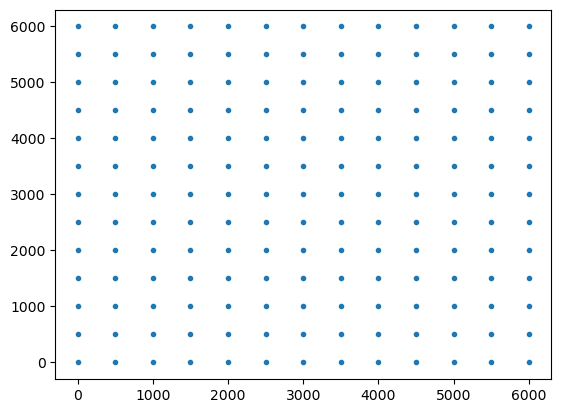

In [3]:
# create receivers
rx_x, rx_y = np.meshgrid(np.arange(0, 6500, 500), np.arange(0, 6500, 500))
receivers = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.ones((np.prod(rx_x.shape), 1))*50.0))
print(f"receiver numbers: {receivers.shape}")

plt.plot(receivers[:, 0], receivers[:, 1], '.')
plt.show()


## Load up UBC data

In [4]:
ubc_read = np.genfromtxt(r".\data_input\FWDdata.txt")

frequencies = [10, 50, 200]
# organise data by frequency index
ubc_dat = {}

for ii in range(len(frequencies)):

    ubc_dat[ii] = {

        'tzxr': [],
        'tzxi': [],
        'tzyr': [],
        'tzyi': [],
    }

fcnt = 0
findx = 0

for ii in range(ubc_read.shape[0]):

    if len(ubc_read[ii, :]) > 1:

        if fcnt == 169:

            fcnt = 0
            findx += 1

            ubc_dat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_dat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_dat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_dat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        else:

            ubc_dat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_dat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_dat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_dat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        fcnt += 1

# print(len(ubc_dat[findx - 1]['tzxr']))

# now create a vectore similar to dobs in simpeg
ubc_obs = []

for ii in range(3):

    ubc_obs += ubc_dat[ii]['tzxr']
    ubc_obs += ubc_dat[ii]['tzxi']
    ubc_obs += ubc_dat[ii]['tzyr']
    ubc_obs += ubc_dat[ii]['tzyi']

print(np.array(ubc_obs).shape)
ubc_obs = np.array(ubc_obs)

(2028,)


## Setting up the simulation

Here the background is set to the median of the model provided. This may or may not need to be adjusted depedning on the experiment.

The simpeg framework is now incorporated by defining the receiver type and components. This can be modified for impedance data or tipper. For tipper data replace the receiver simpeg object type with: `Point3DTipper(receivers, orientation=rx_orientation, component='real')` and `Point3DTipper(receivers, orientation=rx_orientation, component='imag')` on starting on line 12 and 17.

The model slice is also generated to confirm simulated targets.

(-9800.0, 15800.0, -12800.0, 12800.0)

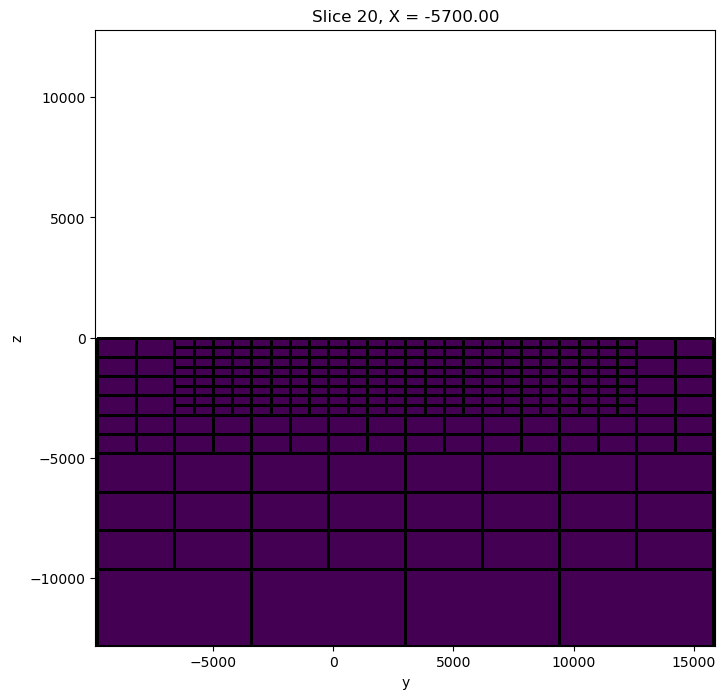

In [5]:
# set frequencies
freqs = ['10', '50', '200']

background = 100 # np.median(model[active])
# create background conductivity model
sigBG = np.zeros(mesh.nC) + 1 / background
sigBG[~active] = 1e-8

# Make a receiver list
rx_list = []
for rx_orientation in ['zx', 'zy']:
    
    rx_list.append(
        
        ns.receivers.Point3DTipper(receivers,
                                   orientation=rx_orientation,
                                   component='real'
        )
    )
    rx_list.append(

        ns.receivers.Point3DTipper(receivers,
                                   orientation=rx_orientation,
                                   component='imag'
        )
    )

# Source list
src_list = [ns.sources.PlanewaveXYPrimary(rx_list, frequency=float(f)) for f in freqs]

# Survey MT
survey = ns.Survey(src_list)
# survey.drape_topography(mesh, active, option='top')                       # drape topo

# plot the mesh
model_plot = model.copy()
model_plot[~active] = np.nan
ind_slice = int(20)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
mesh.plot_slice(model_plot, normal="X", ax=ax, ind=ind_slice, grid=True)
ax.axis("equal")


## Running the forward simulation

Here simpeg map and simulation objects are created which are then used to calculate the forward data using the geological model imported in UBC format.

In [6]:
# Set the mapping
actMap = maps.InjectActiveCells(
    mesh=mesh, indActive=active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * actMap

# Setup the problem (As a multiprocessing meta sim split by source)
# If you don't want to use the MultiprocessingMetaSim branch, you can just comment
# the below lines out and replace sim with the normal sim that is commented out
# below
mappings = []
sims = []
for src in src_list:
    mappings.append(maps.IdentityMap())
    srv_piece = ns.Survey([src,])
    sims.append(ns.Simulation3DPrimarySecondary(
        mesh, survey=srv_piece, sigmaMap=mapping, sigmaPrimary=sigBG, solver=Solver
    ))

sim = MultiprocessingMetaSimulation(sims, mappings)
    
# sim = ns.simulation.Simulation3DPrimarySecondary(
#     mesh,
#     survey=survey,
#     sigmaMap=mapping,
#     sigmaPrimary=sigBG,
#     solver=Solver
# )

sim.model = sigBG[active]

# -------------------------------------------------------------

# calculate the fields

#

import time
source_list = src_list
models = {

    "L_block": np.log(model[active]),
    "half_space": np.log(sigBG[active])
}

fields = {}

t = time.time()
for key, sig in models.items():
    if key not in fields.keys(): 
        print(f"starting {key}")
        t = time.time()
        fields[key] = sim.fields(sig)
        print(f"done {key}... elapsed time: {time.time()-t:1.1e}s \n")

c:\users\johnk\documents\git\simpegmp\SimPEG\meta\multiprocessing.py:159: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  super().__init__(simulations, mappings)
c:\users\johnk\documents\git\simpegmp\SimPEG\meta\multiprocessing.py:178: UserWarning: The MetaSimulation class is a work in progress and might change in the future
  sim_chunk = MetaSimulation(


starting L_block
done L_block... elapsed time: 1.2e-02s 

starting half_space
done half_space... elapsed time: 2.0e+02s 



In [7]:
len(sig), mapping.shape

(34840, (54504, 34840))

In [8]:
fwd_data = sim.make_synthetic_data(sig, f=fields["L_block"], add_noise=False)

## Plotting the simulation data

Line 11 and 20 will need to be adjusted accoringly depending on the data being observed.

169


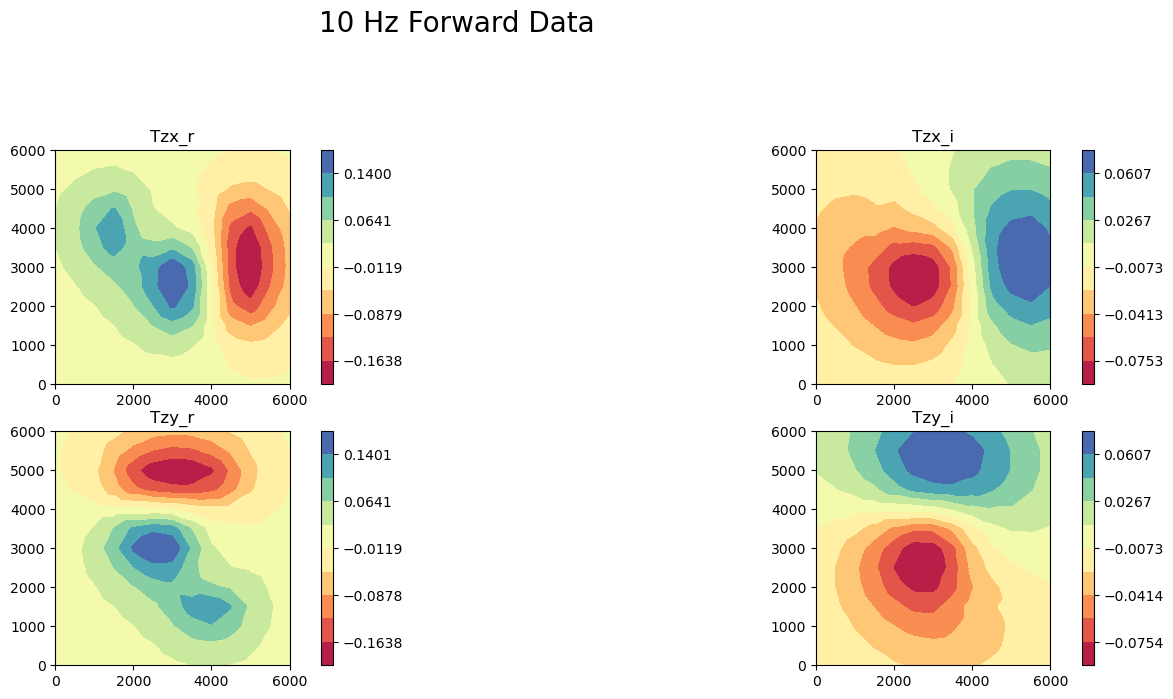

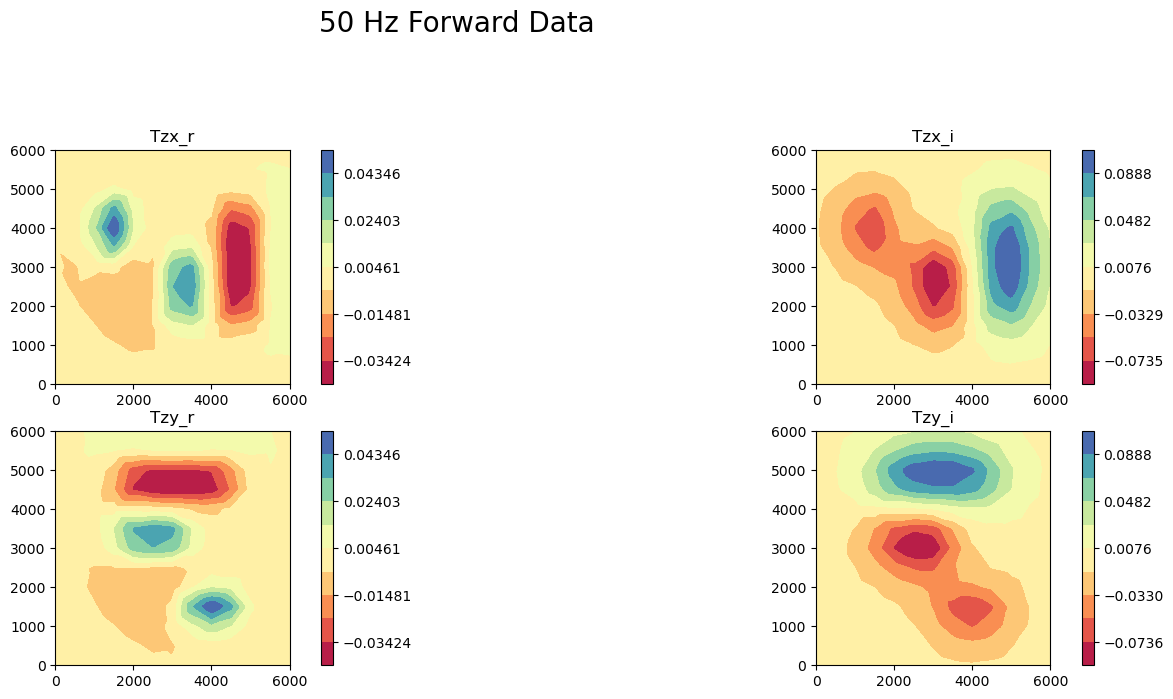

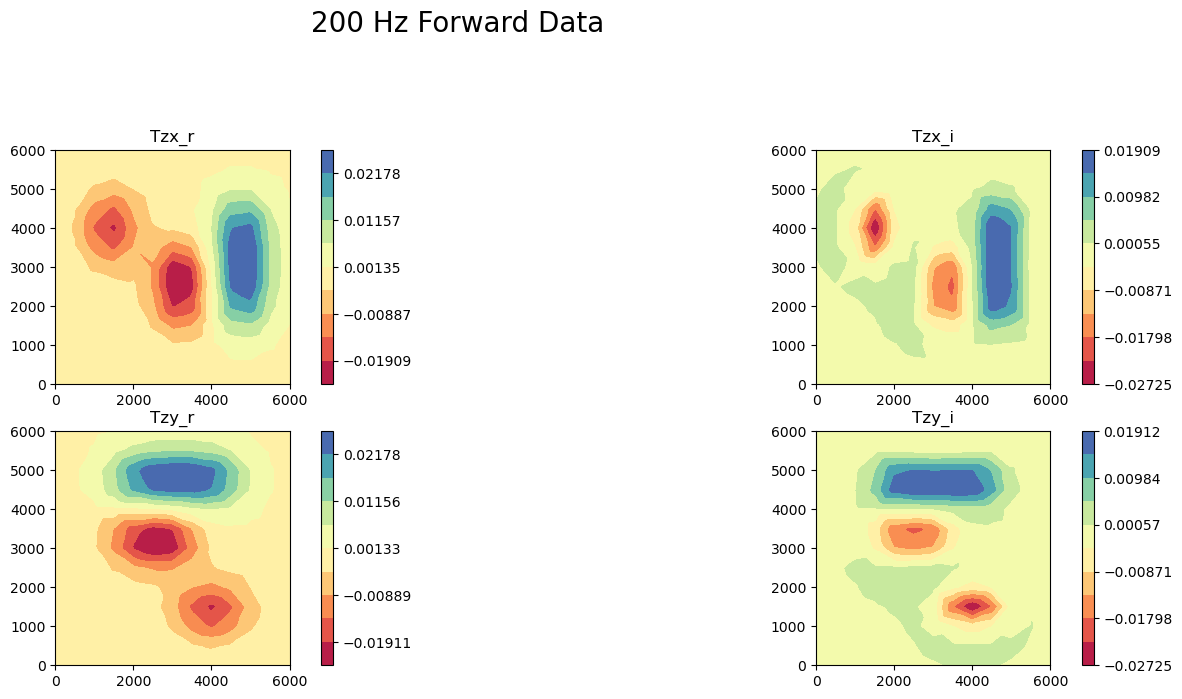

[0.00103239 0.00102858 0.00500256] (2028,)


In [9]:
# Assign uncertainties
fwd_data.relative_error = 0.05  # 5% std
fwd_data.noise_floor = 0.01
# sim.survey.std = np.abs(survey.dobs) * std
fwd_data.noise_floor[-src_list[-1].nD:] = 0.005
# make data object
# fwd_data = data.Data(sim.survey)

# reshape data for plotting
print(receivers.shape[0])
num_station = receivers.shape[0]

num_frequencies = len(freqs)

num_sets = int(fwd_data.dobs.shape[0] / len(freqs))
dnew = np.reshape(fwd_data.dobs, (num_frequencies, num_sets))
stdnew = np.reshape(fwd_data.standard_deviation, (num_frequencies, num_sets))

# do the ubc data
ubc_dnew = np.reshape(ubc_obs, (num_frequencies, num_sets))

cnt = 0

profile_data = {

    '10':{

    'real': [],
    'imag': []

    },

    '50':{

    'real': [],
    'imag': []

    },

    '200':{

    'real': [],
    'imag': []

    }
}

ubc_profile_data = {

    '10':{

    'real': [],
    'imag': []

    },

    '50':{

    'real': [],
    'imag': []

    },

    '200':{

    'real': [],
    'imag': []

    }
}


for freq in freqs:
    cnt_comp = 0
    comps_ = ['Tzx_r', 'Tzx_i', 'Tzy_r', 'Tzy_i']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        pert = 1e-2
        pert_diag = 1e-3  #np.percentile(np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]), 10)
        
        if comps_[rx_orientation][-2:] == 'xx':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        
        elif comps_[rx_orientation][-2:] == 'yy':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        
        elif freq == '200':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.05) + 0.005
        
        else:
#             print(pert_diag)
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.05) + pert_diag

        if comps_[rx_orientation] == 'Tzx_r':
            # print(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)].shape)
            profile_data[freq]['real'].append(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            ubc_profile_data[freq]['real'].append(ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
        
        elif comps_[rx_orientation] == 'Tzx_i':
            profile_data[freq]['imag'].append(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            ubc_profile_data[freq]['imag'].append(ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = utils.plot_utils.plot2Ddata(receivers, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax, contourOpts={'cmap':'Spectral'})
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(freq + ' Hz Forward Data', fontsize='20')
plt.show()
print(mkvc(stdnew)[:3], stdnew.flatten('F').shape)

## Inversion

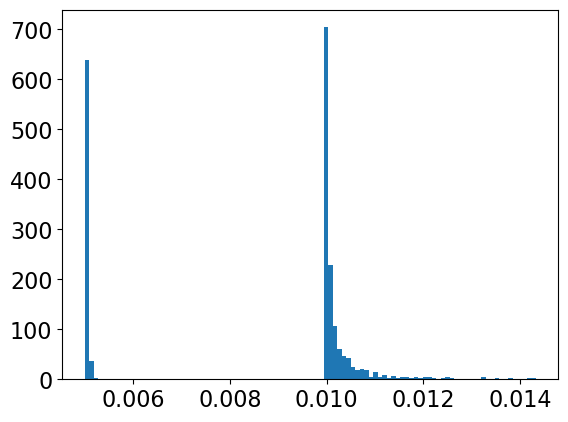

In [13]:
plt.hist(fwd_data.standard_deviation, 100)
plt.show()

# Set the conductivity values
sig_half = 0.01
sig_air = 1e-8
# Make the background model
sigma_0 = np.ones(mesh.nC) * sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

# Setup the inversion proceedure
# Define a counter
# Data misfit
dmis = data_misfit.L2DataMisfit(data=fwd_data, simulation=sim)
# Regularization
regmap = maps.IdentityMap(nP=int(active.sum()))
# reg = regularization.Sparse(mesh, indActive=active, mapping=regmap)

reg = regularization.WeightedLeastSquares(mesh, active_cells=active, mapping=regmap, reference_model=m_0)
reg.alpha_s = 2.5e-5
reg.alpha_x = 1.
reg.alpha_y = 1.
reg.alpha_z = 0.25


# Optimization
C = utils.Counter()
opt = optimization.ProjectedGNCG(maxIter=8, upper=np.inf, lower=-np.inf, tolCG=1E-2, maxIterCG=20, )
opt.counter = C
opt.remember('xc')

# reg.mrefInSmooth = True
# Inversion problem
invProb = inverse_problem.BaseInvProblem(dmis, reg, opt, beta=0.1)
invProb.counter = C
# Beta schedule
beta_cool = directives.BetaSchedule(coolingFactor=5, coolingRate=3)
# Initial estimate of beta
# beta_est = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
# Target misfit stop
targmis = directives.TargetMisfit()
# targmis.target = survey.nD
saveIter = directives.SaveModelEveryIteration()
# Create an inversion object
directive_list = [beta_cool, targmis, saveIter]
inv = inversion.BaseInversion(invProb, directiveList=directive_list)

In [14]:
import time
start = time.time()
# Run the inversion
mopt = inv.run(m_0)
print('Inversion took {0} seconds'.format(time.time() - start))


                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver Pardiso and no solver_opts.***
                    
SimPEG.SaveModelEveryIteration will save your models as: '.\###-InversionModel-2023-04-15-00-16.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e-01  1.09e+04  0.00e+00  1.09e+04    3.31e+02      0              
   1  1.00e-01  7.61e+03  1.28e+04  8.89e+03    4.20e+01      0              
   2  1.00e-01  7.30e+03  1.53e+04  8.83e+03    1.15e+01      0   Skip BFGS  
   3  2.00e-02  7.23e+03  1.60e+04  7.55e+03    1.86e+02      0   Skip BFGS  
   4  2.00e-02  3.31e+03  1.01e+05  5.33e+03    5.02e+01      0              
   5  2.00e-02  2.59e+03  1.23e+05  5.0

## Model Comparison

In [16]:
# load the ubc model

# load the conductivity model
ubc_conductivity_file = r"octree_model/inv_003.con"
ubc_model = mesh.read_model_UBC(ubc_conductivity_file)

print(invProb.phi_d)

471.8055781111851


In [19]:
ubc_read = np.genfromtxt(r".\data_input\dpred_003.txt")

frequencies = [10, 50, 200]
# organise data by frequency index
ubc_pdat = {}

for ii in range(len(frequencies)):

    ubc_pdat[ii] = {

        'tzxr': [],
        'tzxi': [],
        'tzyr': [],
        'tzyi': [],
    }

fcnt = 0
findx = 0

for ii in range(ubc_read.shape[0]):

    if len(ubc_read[ii, :]) > 1:

        if fcnt == 169:

            fcnt = 0
            findx += 1

            ubc_pdat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_pdat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_pdat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_pdat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        else:

            ubc_pdat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_pdat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_pdat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_pdat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        fcnt += 1

# print(len(ubc_dat[findx - 1]['tzxr']))

# now create a vectore similar to dobs in simpeg
ubc_pred = []

for ii in range(3):

    ubc_pred += ubc_pdat[ii]['tzxr']
    ubc_pred += ubc_pdat[ii]['tzxi']
    ubc_pred += ubc_pdat[ii]['tzyr']
    ubc_pred += ubc_pdat[ii]['tzyi']

print(np.array(ubc_pred).shape)
ubc_pred = np.array(ubc_pred)

# do the ubc data
ubc_dpred = np.reshape(ubc_pred, (num_frequencies, num_sets))

(2028,)


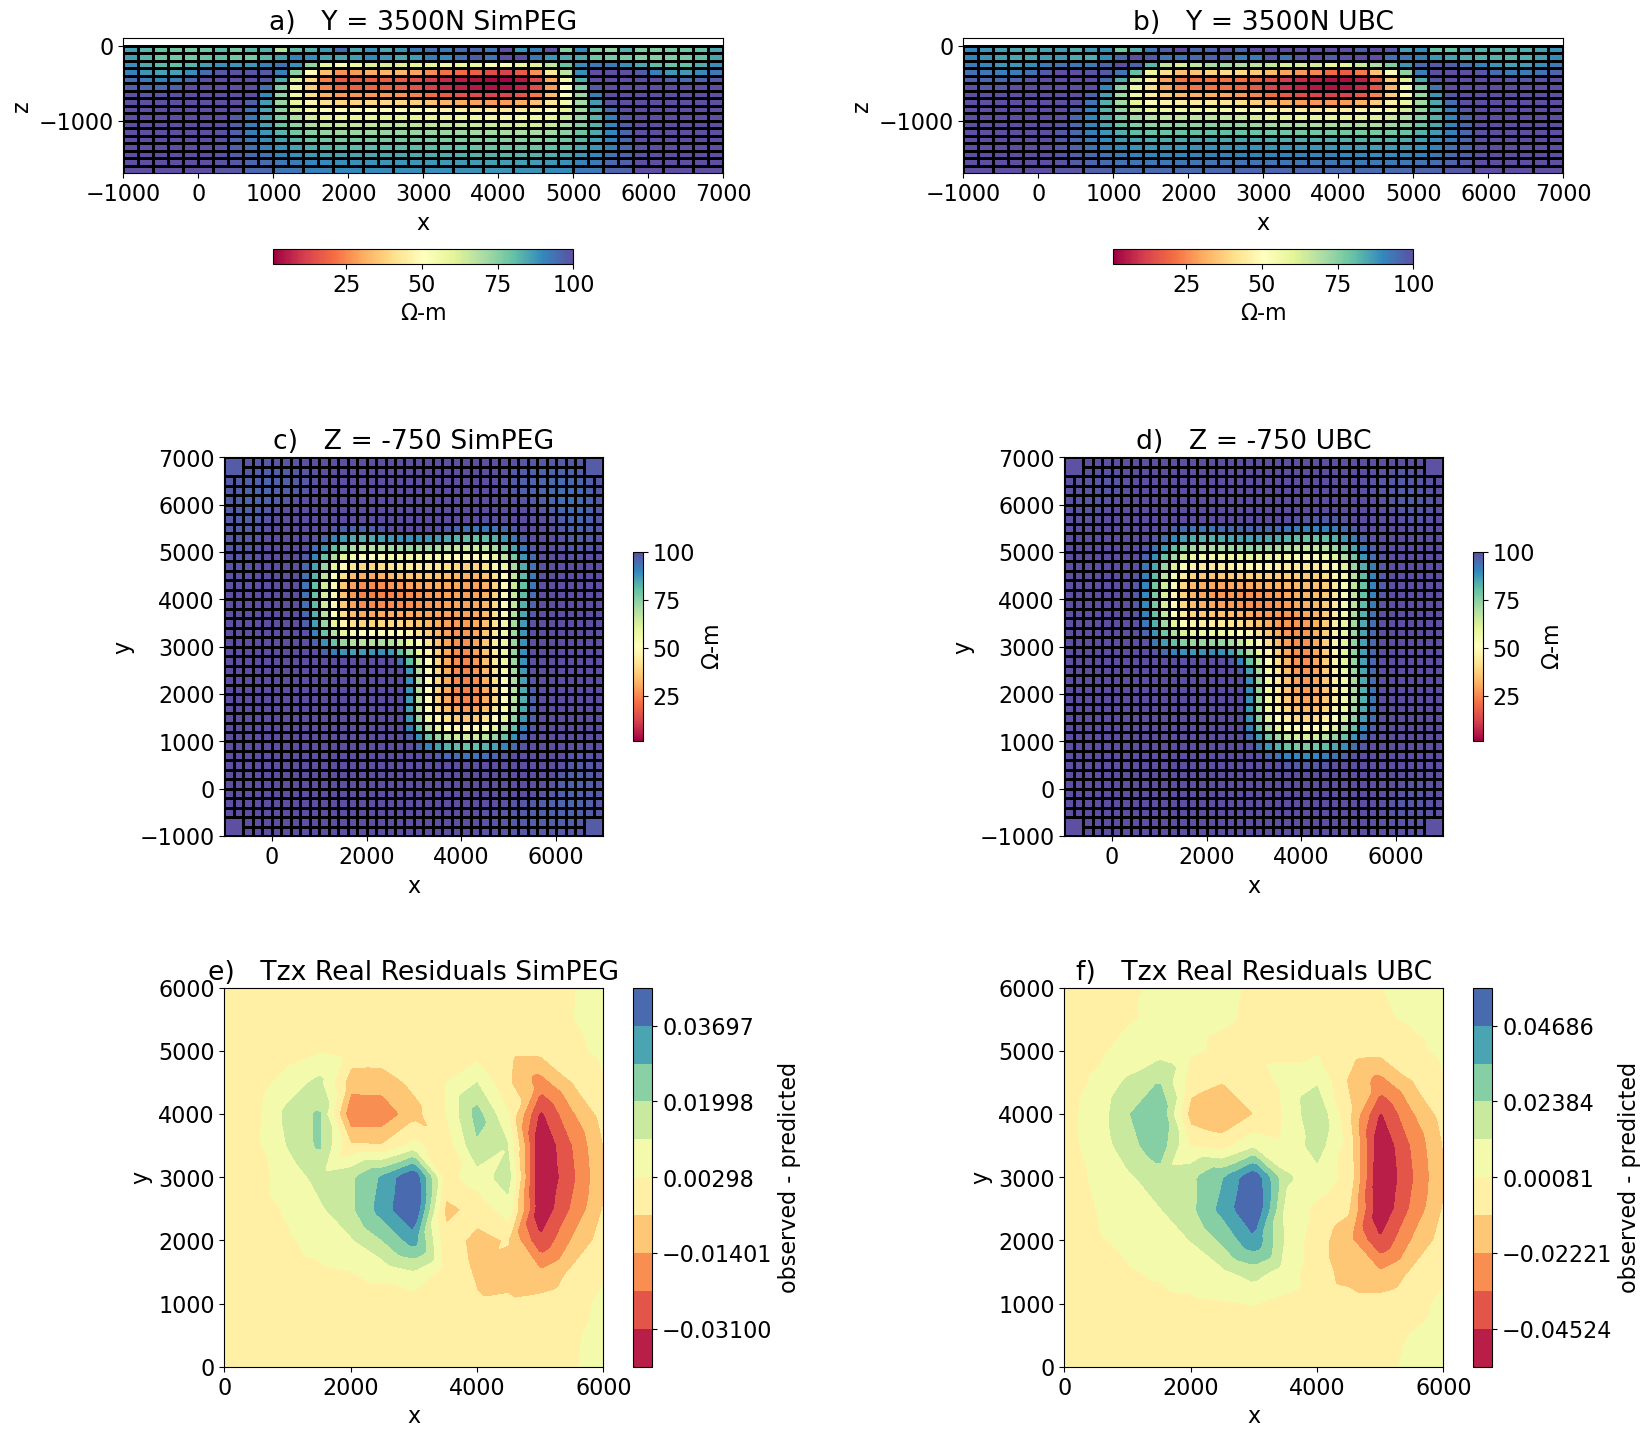

In [59]:
cond_est = np.ones(mesh.nC)
cond_est[active] = np.exp(np.load(r"007-InversionModel-2023-04-15-00-16.npy"))

modeli = 1 / cond_est
modeli[~active] = np.nan
modeli_ubc = 1 / ubc_model
modeli_ubc[~active] = np.nan

plt.figure(figsize=(18, 18))
# plt.suptitle('Model Comparison')
ax = plt.subplot(3, 2, 1)
collect_obj = mesh.plot_slice(modeli, ax=ax, ind=int(66), grid=True, normal='Y', clim=[1, 100], pcolor_opts={'cmap':'Spectral'}, title='wtf')
color_bar = plt.colorbar(collect_obj[0], shrink=0.5, orientation='horizontal', label='$\Omega$-m', pad=0.2)
ax.set_xlim([-1000, 7000])
ax.set_ylim([-1700, 100])
ax.set_aspect('equal')
ax.set_title('a)   Y = 3500N SimPEG')

ax1 = plt.subplot(3, 2, 2)
collect_obj1 = mesh.plot_slice(modeli_ubc, ax=ax1, ind=int(66), grid=True, normal='Y', clim=[1, 100], pcolor_opts={'cmap':'Spectral'})
color_bar1 = plt.colorbar(collect_obj1[0], shrink=0.5, orientation='horizontal', label='$\Omega$-m', pad=0.2)
ax1.set_xlim([-1000, 7000])
ax1.set_ylim([-1700, 100])
ax1.set_aspect('equal')
ax1.set_title('b)   Y = 3500N UBC')

ax2 = plt.subplot(3, 2, 3)
collect_obj2 = mesh.plot_slice(modeli, ax=ax2, ind=int(120), grid=True, normal='Z', clim=[1, 100], pcolor_opts={'cmap':'Spectral'})
color_bar2 = plt.colorbar(collect_obj2[0], shrink=0.5, label='$\Omega$-m')
ax2.set_xlim([-1000, 7000])
ax2.set_ylim([-1000, 7000])
ax2.set_aspect('equal')
ax2.set_title('c)   Z = -750 SimPEG')

ax3 = plt.subplot(3, 2, 4)
collect_obj3 = mesh.plot_slice(modeli_ubc, ax=ax3, ind=int(120), grid=True, normal='Z', clim=[1, 100], pcolor_opts={'cmap':'Spectral'})
color_bar3 = plt.colorbar(collect_obj3[0], shrink=0.5, label='$\Omega$-m')
ax3.set_xlim([-1000, 7000])
ax3.set_ylim([-1000, 7000])
ax3.set_aspect('equal')
ax3.set_title('d)   Z = -750 UBC')

# need to add residual map

num_sets = int(fwd_data.dobs.shape[0] / 3.)
dnew = np.reshape(fwd_data.dobs, (3, num_sets))
dpred_new = np.reshape(invProb.dpred, (3, num_sets))
d_wd = dmis.W.diagonal()
Wd_new = np.reshape(d_wd, (3, num_sets))
ax4 = plt.subplot(3, 2, 5)
ax5 = plt.subplot(3, 2, 6)
cnt = 0
for freq in [freqs[0]]:
    cnt_comp = 0
    # fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):

        if comps_[rx_orientation] == 'Tzx_r':

            residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                        dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            im = utils.plot_utils.plot2Ddata(receivers, residual, ax=ax4, contourOpts={'cmap':'Spectral'})
            ax4.set_title(f"e)   Tzx Real Residuals SimPEG")
            ax4.set_xlabel('x')
            ax4.set_ylabel('y')
            plt.colorbar(im[0], label='observed - predicted')

            residual_ubc = -(ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                            ubc_dpred[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            im = utils.plot_utils.plot2Ddata(receivers, residual_ubc, ax=ax5, contourOpts={'cmap':'Spectral'})
            ax5.set_title(f"f)   Tzx Real Residuals UBC")
            ax5.set_xlabel('x')
            ax5.set_ylabel('y')
            plt.colorbar(im[0], label='observed - predicted')

            cnt_comp += 1

        # elif comps_[rx_orientation] == 'Tzx_i':
    cnt += 1



# fig.tight_layout(pad=15.0)
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

# print(mesh.nCz)

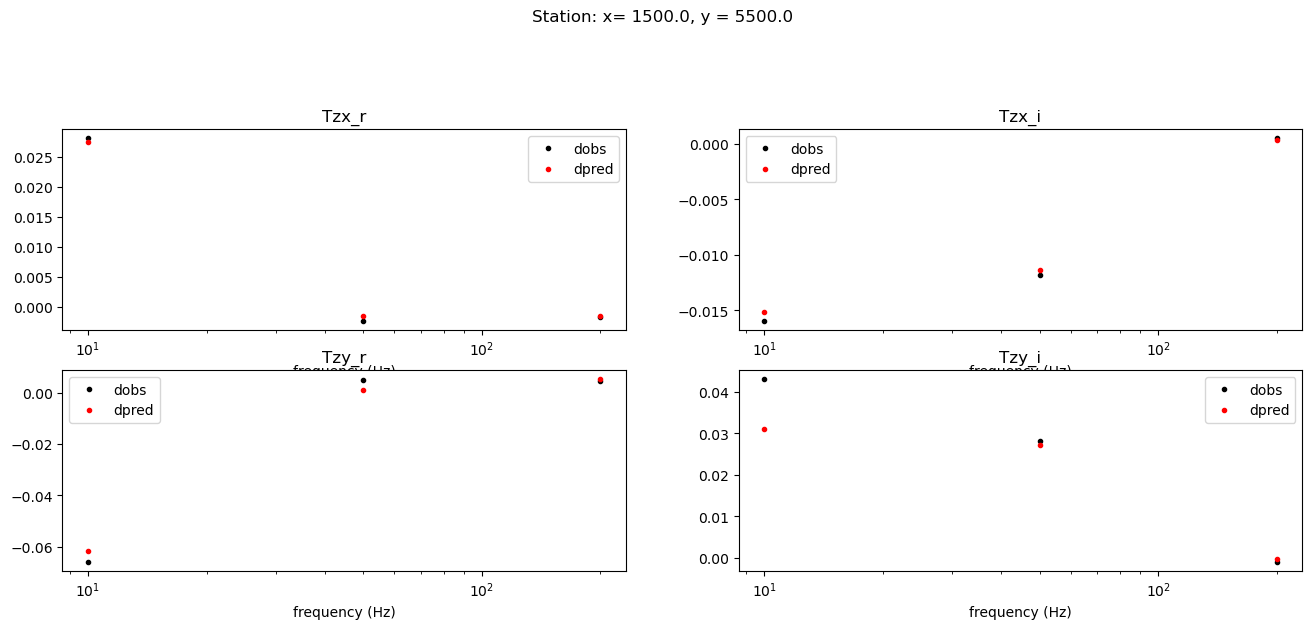

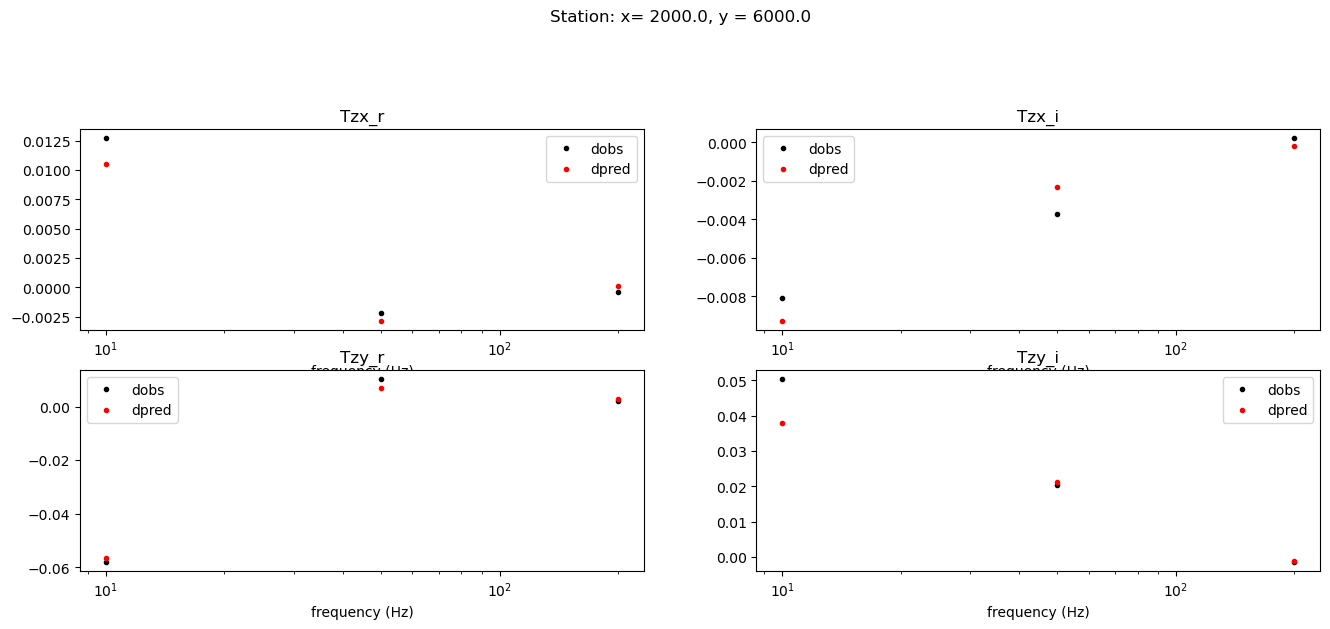

In [50]:
# plot dpred & dobs for specific station - checking fit of each frequency for a station
num_sets = int(fwd_data.dobs.shape[0] / 3.)
dnew = np.reshape(fwd_data.dobs, (3, num_sets))
dpred_new = np.reshape(invProb.dpred, (3, num_sets))
d_wd = dmis.W.diagonal()
Wd_new = np.reshape(d_wd, (3, num_sets))
# set station ID
stn_id = 50
location_id = receivers[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in comps_:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

# set second station ID
stn_id = 64
location_id = receivers[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in comps_:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.frequencies, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.frequencies, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()